# analise do dataset: estrutura e validade dos dados

vamos la, onde estao as imagens e os ficheiros?

In [1]:
import os
import pandas as pd

images_dir = "images/"
images_type = ".jpg"

df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

quantas imagens temos?

In [2]:
a = len([img for img in os.listdir(images_dir) if img.endswith(images_type)])
print(f"Temos {a} imagens na pasta das imagens.")

Temos 4419 imagens na pasta das imagens.


e quantas sao de teste e de treino?

In [3]:
a = len(df_train)
b = len(df_test)

print(f"Temos {a} imagens de treino.")
print(f"Temos {b} imagens de teste.")

Temos 6791 imagens de treino.
Temos 1107 imagens de teste.


provavelmente temos imagens repetidas...

In [4]:
a = df_train['ID'].duplicated().sum()
b = df_test['ID'].duplicated().sum()

print(f"Temos {a} imagens repetidas no treino.")
print(f"Temos {b} imagens repetidas no teste.")

Temos 3479 imagens repetidas no treino.
Temos 0 imagens repetidas no teste.


confirma-se, vamos ver então se são iguais ou como é

In [5]:
df_train2 = df_train.copy()
df_train2.set_index("ID", inplace=True)

df_train2.loc["ID024YTBkLvRpQahT"]

,img_origin,placement,boil_nbr,pan_nbr,polygon
ID,,,,,
ID024YTBkLvRpQahT,D,roof,0,1,"[(1574, 526.0), (1698, 366.0), (1810, 422.0), ..."
ID024YTBkLvRpQahT,D,roof,0,2,"[(1402, 782.0), (1814, 854.0), (1726, 1074.0),..."
ID024YTBkLvRpQahT,D,roof,0,2,"[(2042, 2238.0), (2362, 2326.0), (2290, 2474.0..."


após análise, verifica-se que não são "repetidos", são é 3 conjuntos de painéis, totalizando neste caso 5, e cada poligono é um conjunto. devemos juntar tudo numa só linha para depois dar ao modelo

mas antes temos de mudar o tipo de dados do polygon para lista de tuplos de floats (atualmente é string!)

In [6]:
def treat_polygon_column(value):
    try:
        new_value = []
        value = value.replace("[", "").replace("]", "").replace(" ", "").replace("(","").split("),")
        for coord in value:
            coord = coord.replace(")", "")
            x,y = coord.split(",")
            new_value.append((float(x), float(y)))
        return new_value

    except:
        if value == ['2250,3318.0', '1639,3334.0', "'6707z2',3334.0", '1642,3233.0', '2248,3221.0)']:
            return [2250,3318.0, 1639,3334.0, 6707.2,3334.0, 1642,3233.0, 2248,3221.0]

        else:
            print(value)
            return value

df_train['polygon'] = df_train['polygon'].apply(treat_polygon_column)

agora vamos juntar as linhas, mas como pode haver boiler e pan, convem fazer uma coluna para os polygon de cada um, e podemos entao remover o polygon

In [7]:
df_train['boil_polygon'] = df_train.apply(lambda row: row["polygon"] if row["boil_nbr"] != 0 else [], axis=1)
df_train['pan_polygon'] = df_train.apply(lambda row: row["polygon"] if row["pan_nbr"] != 0 else [], axis=1)

antes:

In [8]:
df_train[df_train["ID"] == "ID024YTBkLvRpQahT"]

,ID,img_origin,placement,boil_nbr,pan_nbr,polygon,boil_polygon,pan_polygon
3,ID024YTBkLvRpQahT,D,roof,0,1,"[(1574.0, 526.0), (1698.0, 366.0), (1810.0, 42...",[],"[(1574.0, 526.0), (1698.0, 366.0), (1810.0, 42..."
4,ID024YTBkLvRpQahT,D,roof,0,2,"[(1402.0, 782.0), (1814.0, 854.0), (1726.0, 10...",[],"[(1402.0, 782.0), (1814.0, 854.0), (1726.0, 10..."
5,ID024YTBkLvRpQahT,D,roof,0,2,"[(2042.0, 2238.0), (2362.0, 2326.0), (2290.0, ...",[],"[(2042.0, 2238.0), (2362.0, 2326.0), (2290.0, ..."


depois:

In [9]:
# juntar linhas numa só, através de listas
df_train2 = pd.DataFrame(df_train.groupby(['ID']).agg({
    'boil_nbr': lambda x: list(x), #'sum'
    'pan_nbr': lambda x: list(x), #'sum'
    'boil_polygon': lambda x: list(x),
    'pan_polygon': lambda x: list(x)
})).reset_index()

# voltar a juntar colunas: img_origin e placement
df_train2 = df_train2.merge(df_train[["ID", "img_origin", "placement"]], how="inner", on="ID")

# remover listas vazias dos polygons
def remove_empty_lists(value):
    new_value = [v for v in value if v != []]
    return new_value
df_train2["boil_polygon"] = df_train2["boil_polygon"].map(remove_empty_lists)
df_train2["pan_polygon"] = df_train2["pan_polygon"].map(remove_empty_lists)

# remover zeros dos nbr para que length seja igual a dos polygons
def remove_zeros(value):
    new_value = [v for v in value if v != 0]
    return new_value
df_train2["boil_nbr"] = df_train2["boil_nbr"].map(remove_zeros)
df_train2["pan_nbr"] = df_train2["pan_nbr"].map(remove_zeros)

# reescrever em df_train e remover duplicados
df_train = df_train2.copy()
df_train.drop_duplicates("ID", inplace=True)
df_train.reset_index(drop=True, inplace=True)

# resultado final
df_train[df_train["ID"] == "ID024YTBkLvRpQahT"]

,ID,boil_nbr,pan_nbr,boil_polygon,pan_polygon,img_origin,placement
3,ID024YTBkLvRpQahT,[],"[1, 2, 2]",[],"[[(1574.0, 526.0), (1698.0, 366.0), (1810.0, 4...",D,roof


será que ja temos tantas linhas como imagens?

In [10]:
len(df_train) + len(df_test) == len([img for img in os.listdir(images_dir) if img.endswith(images_type)])

True

parece que sim, temos então a estrutura de dados:

In [11]:
df_train.sample(3)

,ID,boil_nbr,pan_nbr,boil_polygon,pan_polygon,img_origin,placement
2010,IDaOtIgjbhD0amC,[],"[4, 1]",[],"[[(1823.0, 1442.0), (2403.0, 1422.0), (2439.0,...",D,roof
145,ID2X0lJvPOVU9w4KU,[],[10],[],"[[(302.0, 386.0), (209.0, 328.0), (249.0, 264....",S,S-unknown
3040,IDubNBGQQSKE,[],"[2, 1]",[],"[[(4672.0, 2982.0), (4651.0, 2811.0), (4852.0,...",D,roof


In [12]:
df_test.sample(3)

,ID,img_origin,placement
450,IDNXDxhOyEQBn28n,D,openspace
720,IDdjUTm9nGY,S,S-unknown
300,IDHIi7sOPf,D,roof


vamos guardar os dados de treino por causa das transformacoes

In [13]:
df_train.to_pickle("Train_v01.pkl")

# verificar se o pickle está correto
df_train = pd.read_pickle("Train_v01.pkl")
df_train.sample(3)

,ID,boil_nbr,pan_nbr,boil_polygon,pan_polygon,img_origin,placement
2718,IDo2jsCGXE,[],"[1, 1]",[],"[[(1730.0, 626.0), (1867.0, 557.0), (1908.0, 6...",D,roof
520,ID8tyAqF9bv,[],"[1, 1]",[],"[[(1702.0, 1473.0), (1962.0, 1682.0), (1893.0,...",D,roof
1041,IDIxbudJIyNOaARlD,[],[1],[],"[[(2479.0, 1819.0), (3055.0, 1804.0), (2955.0,...",D,roof


---

o site/concurso indica que pode haver erros ou desvios dos poligonos face as verdadeiras posicoes dos boilers e paineis, ha q verificar

In [14]:
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np

def polygons_to_segmentation_mask(polygons, image):
    for polygon, val in polygons:
        poly = np.array([polygon], dtype=np.int32)
        cv2.fillPoly(image, [poly], val)
    return image

class SupervisedDataset(Dataset):
    def __init__(self, data_path, dataframe, transforms):
        self.root_path = data_path
        self.transforms = transforms
        self.data = dataframe

        self.images = []
        self.targets = []
        self.vertex_boil = []
        self.vertex_pan = []
        self.nr_boild = []
        self.nr_pan = []
        self.id = []

        for idx in self.data.index:
            #if self.data['ID'][idx] not in ['IDmfKSa','IDa5zIYY2ZvtkGpp'] and self.data['ID'][idx] not in drop1:
            self.images.append(os.path.join(self.root_path, self.data['ID'].iloc[idx] + '.jpg'))
            self.vertex_boil.append(self.data['boil_polygon'].iloc[idx])
            self.vertex_pan.append(self.data['pan_polygon'].iloc[idx])
            self.nr_boild.append(self.data['boil_nbr'].iloc[idx])
            self.nr_pan.append(self.data['pan_nbr'].iloc[idx])
            self.id.append(self.data['ID'].iloc[idx])

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        size = img.size
        img = self.transforms(img)
        vertices_boil = self.vertex_boil[idx]
        vertex_pan = self.vertex_pan[idx]

        mask = np.zeros((img.shape[1],img.shape[2]),dtype = np.int32)
        id1 = self.id[idx]
        all_polygons = []
        for polygon in vertices_boil:
            lst2 = []
            lst1 = []
            for i in range(len(polygon)):
                v1 = list(polygon[i])
                v1[0] = (v1[0]*512)/size[0]
                v1[1] = (v1[1]*512)/size[1]
                #if id1 in left1:
                #    v1[0] += 64
                #    v1[1] += 64
                #elif id1 in right1:
                #    v1[0] -= 83
                #    v1[1] -= 83
                lst2.append((v1[0],v1[1]))
            lst1.append(lst2)
            lst1.append(5) #boiler
            all_polygons.append(lst1)
        for polygon in vertex_pan:
            lst2 = []
            lst1 = []
            for i in range(len(polygon)):
                v1 = list(polygon[i])
                v1[0] = (v1[0]*512)/size[0]
                v1[1] = (v1[1]*512)/size[1]
                #if id1 in left1:
                #    v1[0] += 64
                #    v1[1] += 64
                #elif id1 in right1:
                #    v1[0] -= 83
                #    v1[1] -= 83
                lst2.append((v1[0],v1[1]))
            lst1.append(lst2)
            lst1.append(6) #pan
            all_polygons.append(lst1)
        mask = polygons_to_segmentation_mask(all_polygons, mask)
        return img, mask.astype(int)
    
transforms = T.Compose([
    T.Resize((512,512)),  # Resize to a fixed size
    T.ToTensor(),          # Convert to PyTorch tensor
])
data_path = 'images'
train_data = SupervisedDataset(data_path, df_train, transforms)

vamos entao agora ver um exemplo de imagem e poligonos para ver se esta tudo certo, de preferencia uma que tenha boiler e painel

In [15]:
for i in range(1, len(df_train)):
    if df_train.pan_nbr[i] != [] and df_train.boil_nbr[i] != []:
        print(df_train.ID[i])
        print(i)
        break

ID1emKaMYPCA0XY
100


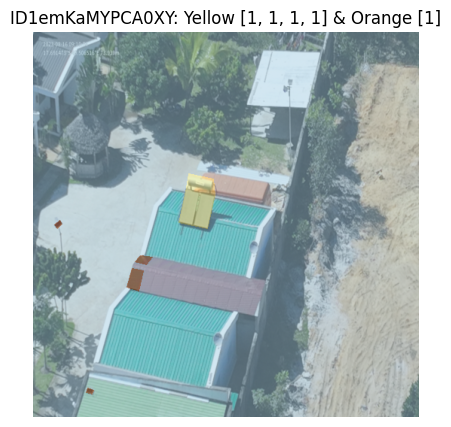

In [16]:
import matplotlib.pyplot as plt
import numpy as np  

# Get the image and the mask
img, mask = train_data[100]
img = img.permute(1, 2, 0).numpy()  # Convert the image tensor to a numpy array (H, W, C)

plt.figure(figsize=(10, 5))  

# Plot the image and the mask
plt.imshow(img)
plt.imshow(mask, cmap='Paired', alpha=0.5)

# Add some sort of help in the veracity check process
plt.title(f'{train_data.id[100]}: Yellow {train_data.nr_pan[100]} & Orange {train_data.nr_boild[100]}')
plt.axis('off')
plt.show()


---

agora a ideia é então automatizar o processo de verificar se os poligonos estao corretos

a ideia é:

- nova coluna para keep track do estado do polygon

- escolher uma imagem sem estado do polygon

- ver a imagem e poligonos

- responder se esta boa, mais para a direita ou esquerda, ...

- registar resposta e passar para a proxima

- de X em X iteracoes, guardar o estado do dataset

In [17]:
#df_train_new = pd.read_pickle("Train_v01.pkl")
#df_train_new["hows_polygon"] = [None] * len(df_train_new)
#df_train_new.to_pickle("Train_v02.pkl")
df_train_new = pd.read_pickle("Train_v02.pkl")


def get_image_and_mask(index):
    img, mask = train_data[index]
    img = img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.imshow(mask, cmap='Paired', alpha=0.5)
    plt.title(f'{train_data.id[index]}: Yellow {train_data.nr_pan[index]} & Orange {train_data.nr_boild[index]}')
    plt.axis('off')
    plt.show()

# loop para verificacao das imagens
for index, row in df_train_new.iterrows():
    if row["hows_polygon"] == None:
        row_id = row["ID"]

        # verificar se o id está correto
        if train_data.id[index] != row_id:
            print(f"Erro: {index} - {row_id} - {train_data.id[index]}")
            break

        # se o id estiver correto, mostrar a imagem
        get_image_and_mask(index)
        hows_polygon = input("How's the polygon? ok, quase, a direita, a esquerda ou exit? ")
        while hows_polygon not in ["exit", "ok", "quase", "a direita", "a esquerda"]:
            hows_polygon = input("How's the polygon? ok, quase, a direita, a esquerda ou exit? ")

        # se o input for diferente de "exit", guardar o input
        if hows_polygon != "exit":
            df_train_new.loc[index, "hows_polygon"] = hows_polygon

        # se o input for "exit", parar o loop
        elif hows_polygon == "exit":
            df_train_new.to_pickle("Train_v02.pkl")
            break

        # guardar a cada 10 iterações
        if index % 10 == 0:
            df_train_new.to_pickle("Train_v02.pkl")

df_train_new.to_pickle("Train_v02.pkl")
print("Processo de verificação terminado.")

Processo de verificação terminado.


fazer uma cópia à mao just in case: Train_v03.pkl

In [18]:
df_with_polygon_status = pd.read_pickle("Train_v03.pkl")

df_with_polygon_status["hows_polygon"].value_counts()

hows_polygon
ok            2767
quase          260
a direita      160
a esquerda     123
lixo             2
Name: count, dtype: int64